In [1]:
#pip install pyproj
from sklearn import manifold
from matplotlib import pyplot as plt
import numpy as np
from pyproj import Transformer
import geopy.distance
import random
import math
from typing import List, Tuple
import pandas as pd
from math import radians, cos, sin, asin, sqrt, isnan

Radius used in KM:  0.7083073901544101 equivalent to degrees: 0.006369961395977689


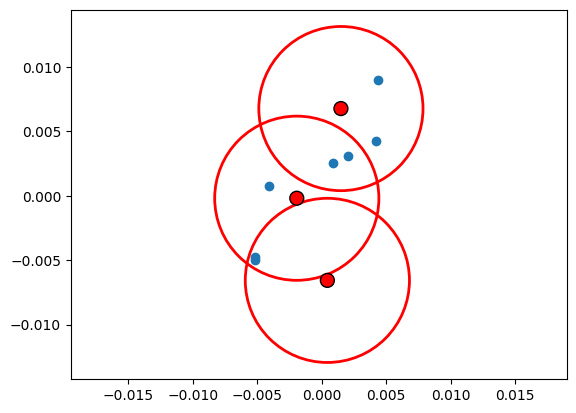

In [2]:
transformer = Transformer.from_crs('epsg:3857', 'epsg:4326')

def cartesian_to_geo(x, y):
    return transformer.transform(x, y)

def to_km_distance(coords):
    size = len(coords) # No of nodes
    distances = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            distances[i, j] = geopy.distance.geodesic(coords[i], coords[j]).km # ??
    return distances

def km_to_deg(d):
    earth_radius = 6371
    return 180 * d / (np.pi * earth_radius)

def delay_to_geo(delay_matrix): # Establish the coordinates of each server according to the delay matrix
    size = len(delay_matrix) # No of nodes
    mds_model = manifold.MDS(n_components=2, random_state=0, dissimilarity='precomputed', normalized_stress="auto") # MDS(dissimilarity='precomputed', normalized_stress='auto', random_state=0)
    mds_model.fit(delay_matrix)
    coords = mds_model.fit_transform(delay_matrix) # [[-711.64291427 -379.86399722][..][..]]
    for i in range(size):
        coords[i] = cartesian_to_geo(*coords[i]) # [[-0.0034123763 -0.0063927971][..][..]]

    return coords

def get_radius(coords, scale_factor = 0.9): # The greater the scale_factor the higher the intersection between the nodes
    size = len(delay_matrix) # No of nodes
    node_rad_scale_factor = math.sqrt(math.sqrt(size)) / scale_factor 
    distances = to_km_distance(coords)
    distances = np.tril(distances, k=0) # distance in km between the nodes
    average_distance = np.sum(distances)/((size*size)/2-size/2)
    km_radius = average_distance/node_rad_scale_factor
    deg_radius = km_to_deg(km_radius)
    return km_radius, deg_radius

def place_users_close_to_nodes(users: int, node_coords):
    size = len(node_coords)
    user_coords = []
    radius = get_radius(node_coords)[1]
    for i in range(users):
        node_coord = node_coords[random.choice(range(size))]
        user_coord = []
        alpha = 2 * math.pi * random.random()
        r = radius * random.random()
        user_coord.append(node_coord[0] + r*math.cos(alpha))
        user_coord.append(node_coord[1] + r*math.sin(alpha))
        user_coords.append(user_coord)
    return np.array(user_coords)

def plot(node_coords, user_coords):
    size = len(node_coords)
    colors = ['r'] * size
    sizes = [100] * size
    ax = plt.gca()

    ax.axis("equal")
    radius = get_radius(node_coords)[1]
    plt.scatter(user_coords[:,0], user_coords[:,1])

    for coord in node_coords:
        cir = plt.Circle(coord, radius, color='r', fill=False, linewidth=2)
        ax.add_patch(cir)
    
    plt.scatter(node_coords[:,0], node_coords[:,1], c=colors, s=sizes, edgecolor='black')

    plt.show()




# EXAMPLE USAGE

max_delay = 2000 # millis
num_nodes = 3 # random.randint(3, 20) # gen some nodes
num_users = 8 # random.randint(num_nodes*2, num_nodes*50) # gen some users

# creates a diagonal matrix of delays (in Neptune this is given)
b = np.random.randint(0, max_delay, size=(num_nodes,num_nodes))
delay_matrix = (b + b.T)/2
np.fill_diagonal(delay_matrix, 0)


node_coords = delay_to_geo(delay_matrix)
radius = get_radius(node_coords)
print("Radius used in KM: ", radius[0], "equivalent to degrees:",  radius[1])
user_coords = place_users_close_to_nodes(num_users, node_coords)
plot(node_coords, user_coords)

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [4]:
# Incoming requests to node i
# Function(rows) x Node(column) [request/sec]
lambda_ri=[[1,0,0],[2,0,1],[1,1,1],[2,0,0]] 

# Amount of request received in time-slot
R=np.sum(lambda_ri)

# Identifies which user sent the request [U x R]
#req_u =np.zeros([num_users,R])
req_u=[[1,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,0,0,0,0],
       [0,0,1,0,0,0,0,0,0],
       [0,0,0,1,0,0,0,0,0],
       [0,0,0,0,1,0,0,0,0],
       [0,0,0,0,0,1,0,0,0],
       [0,0,0,0,0,0,1,0,0],
       [0,0,0,0,0,0,0,1,1]]

U_ni = [] # Set of requests conected to node n

#radius = np.full(num_nodes, 0.03)

In [5]:
for i in range(num_nodes):
  node_latitude = node_coords[i,0]
  node_longitude = node_coords[i,1]
  temp = []
  for r in range(R):
    for u in range(num_users):
      if req_u[u][r]==1:
        request_latitude = user_coords[u,0]
        request_longitude = user_coords[u,1]
        dist_geo = haversine(node_longitude, node_latitude, request_longitude, request_latitude)
        if dist_geo <= radius[0]:
          temp.append(1)
        else:
          temp.append(0)
       
  U_ni.append(temp)